In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from autoprot_dev import analysis as ana
from autoprot_dev import preprocessing as pp
from autoprot_dev import visualization as vis

Checking R installation...
Loading required package: rrcovNA
Loading required package: rrcov
Loading required package: robustbase
Scalable Robust Estimators with High Breakdown Point (version 1.7-2)
Scalable Robust Estimators with High Breakdown Point for
Incomplete Data (version 0.4-15)
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0     ✔ purrr   1.0.1
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 1.0.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: BiocManager
Bioconductor version '3.16' is out-of-date; the current release version '3.19'
is available with R version '4.4'; see https://bioconductor.org/install
Loading required package: devtools
Loading required package: usethis
Attaching package: ‘devtools’
The 

In [2]:
pg = pp.read_csv("../txt/proteinGroups.txt")
pg = pp.cleaning(pg)
print(f"Identified a total of {pg.shape[0]} protein groups")

1453 rows before filter operation.
1287 rows after filter operation.
Identified a total of 1287 protein groups


In [3]:
pg["Gene names first"] = pg["Gene names"].str.split(";").str[0]

In [4]:
# replace 0 by np nan before vsn normalisatoin
lfq_intens = pg.filter(regex="^LFQ intensity").columns.tolist()
pg[lfq_intens] = pg[lfq_intens].replace(0, np.nan)

In [5]:
# loading correction
low_injection = [x for x in lfq_intens if ("ZNF703_" in x) and x.endswith("_3")]
pg[low_injection] *= 14 / 7.5  # 7.5 uL injected vs. 14 uL in the rest

In [6]:
pg, log_intens = pp.log(pg, lfq_intens, return_cols=True)

In [7]:
# sort the log intens list
log_intens = sorted(
    log_intens,
    key=lambda string: string.split(" ")[-1].split("_")[0]
    + string.split(" ")[-1].split("_")[2]
    + string.split(" ")[-1].split("_")[1],
)

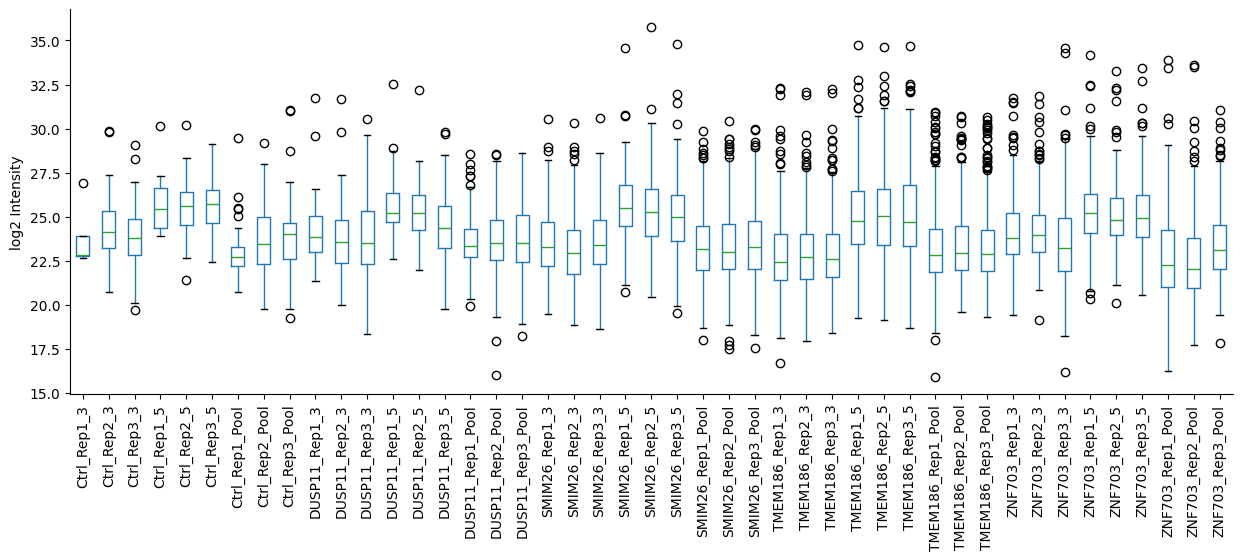

In [8]:
vis.boxplot(pg, log_intens, labels=[x.split(" ")[2] for x in log_intens])
plt.xticks(rotation=90)
plt.ylabel("log2 Intensity")
plt.show()

In [9]:
grouped_exps = []

for exp in ["Ctrl", "DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    for frac in ["3", "5", "Pool"]:
        grouped_exps.append(
            [f"LFQ intensity {exp}_Rep{rep}_{frac}" for rep in range(1, 4)]
        )

grouped_exps[0]

['LFQ intensity Ctrl_Rep1_3',
 'LFQ intensity Ctrl_Rep2_3',
 'LFQ intensity Ctrl_Rep3_3']

In [10]:
# per experiment vsn
for group in grouped_exps:
    print("Normalizing group: " + ", ".join(group))
    pg = pp.vsn(pg, group, print_r=False)

Normalizing group: LFQ intensity Ctrl_Rep1_3, LFQ intensity Ctrl_Rep2_3, LFQ intensity Ctrl_Rep3_3
Normalizing group: LFQ intensity Ctrl_Rep1_5, LFQ intensity Ctrl_Rep2_5, LFQ intensity Ctrl_Rep3_5
Normalizing group: LFQ intensity Ctrl_Rep1_Pool, LFQ intensity Ctrl_Rep2_Pool, LFQ intensity Ctrl_Rep3_Pool
Normalizing group: LFQ intensity DUSP11_Rep1_3, LFQ intensity DUSP11_Rep2_3, LFQ intensity DUSP11_Rep3_3
Normalizing group: LFQ intensity DUSP11_Rep1_5, LFQ intensity DUSP11_Rep2_5, LFQ intensity DUSP11_Rep3_5
Normalizing group: LFQ intensity DUSP11_Rep1_Pool, LFQ intensity DUSP11_Rep2_Pool, LFQ intensity DUSP11_Rep3_Pool
Normalizing group: LFQ intensity SMIM26_Rep1_3, LFQ intensity SMIM26_Rep2_3, LFQ intensity SMIM26_Rep3_3
Normalizing group: LFQ intensity SMIM26_Rep1_5, LFQ intensity SMIM26_Rep2_5, LFQ intensity SMIM26_Rep3_5
Normalizing group: LFQ intensity SMIM26_Rep1_Pool, LFQ intensity SMIM26_Rep2_Pool, LFQ intensity SMIM26_Rep3_Pool
Normalizing group: LFQ intensity TMEM186_Rep1_

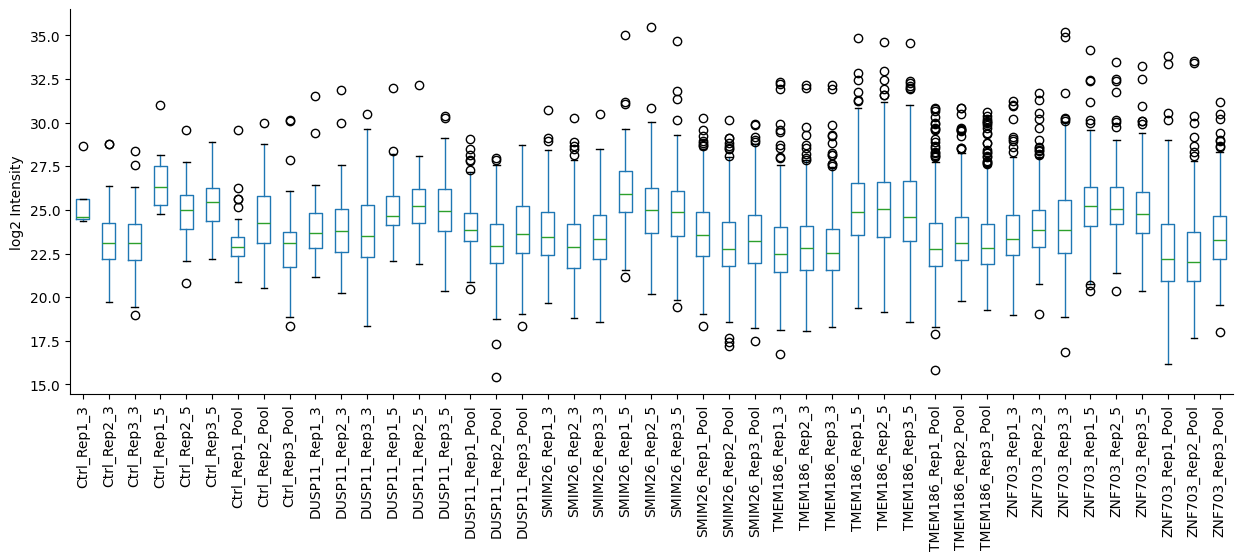

In [11]:
vsn_norm_cols = pg.filter(regex="normalized").columns.tolist()

vis.boxplot(
    pg,
    vsn_norm_cols,
    labels=[x.split(".")[2][:-11] for x in vsn_norm_cols],
)
plt.xticks(rotation=90)
plt.ylabel("log2 Intensity")
plt.show()

In [12]:
# Sum VSN intensities for experiments
def sum_of_logs(array):
    values = np.exp(array)
    sum_of_values = np.nansum(values)
    return np.log(sum_of_values)


for exp in ["Ctrl", "DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    for rep in range(1, 4):
        sub_df = pg.filter(regex=f"LFQ\.intensity\.{exp}_Rep{rep}.*")
        # sum all slices per replicate
        pg[f"sum_norm_intens_{exp}_Rep{rep}"] = sub_df.dropna(how="all").apply(
            sum_of_logs, axis=1
        )

    # # normalize between biological replicates by summed intensity
    # cols = pg.filter(regex=f"sum_norm_intens_{exp}_Rep\d*").columns.tolist()
    # mean_intens = pg[cols].sum(axis=0).mean()
    # # normalize to mean intens
    # pg[cols] *= mean_intens / pg[cols].sum(axis=0)

We cannot normalize to the summed intensity per Rep as the number of proteins between reps are different (and the overall number is small). Thereby we would completely shift the median ratio if we normalize by the total. Moreover, we cannot be sure about the the total being equal as different expression levels in different biological replicates might play a role.

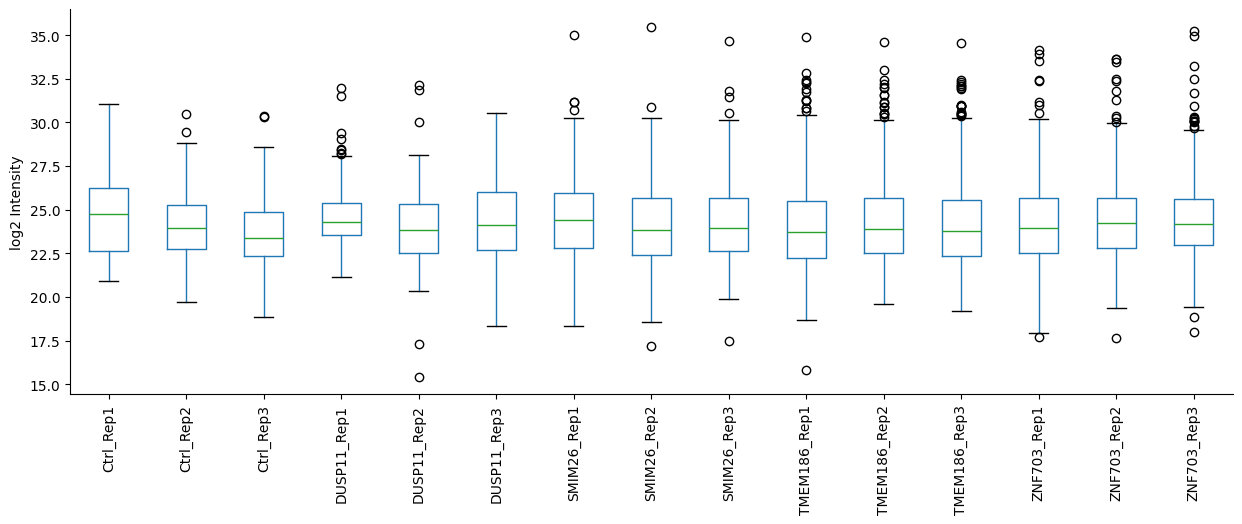

In [13]:
cols_to_plot = pg.filter(regex="sum_norm_intens").columns.tolist()

vis.boxplot(
    pg,
    cols_to_plot,
    labels=[x[16:] for x in cols_to_plot],
)
plt.xticks(rotation=90)
plt.ylabel("log2 Intensity")
plt.show()

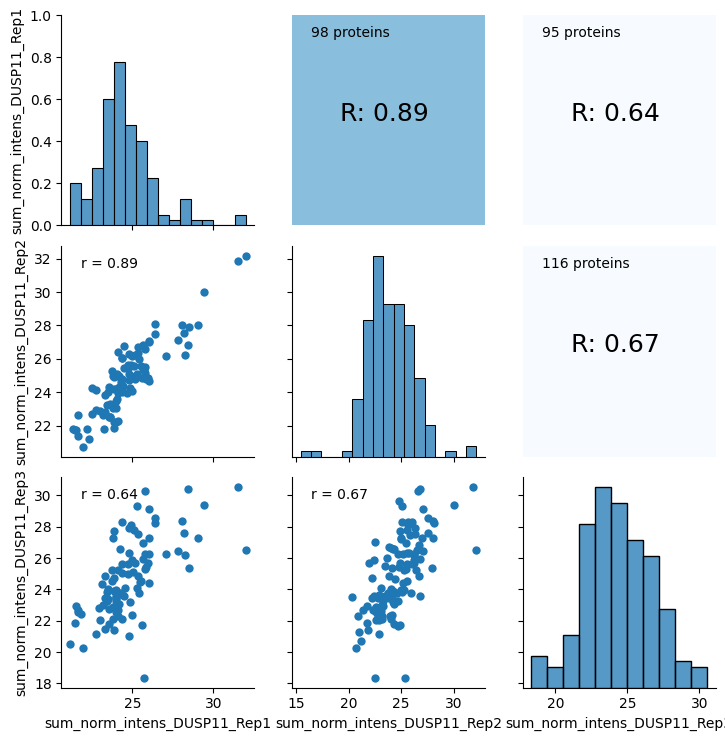

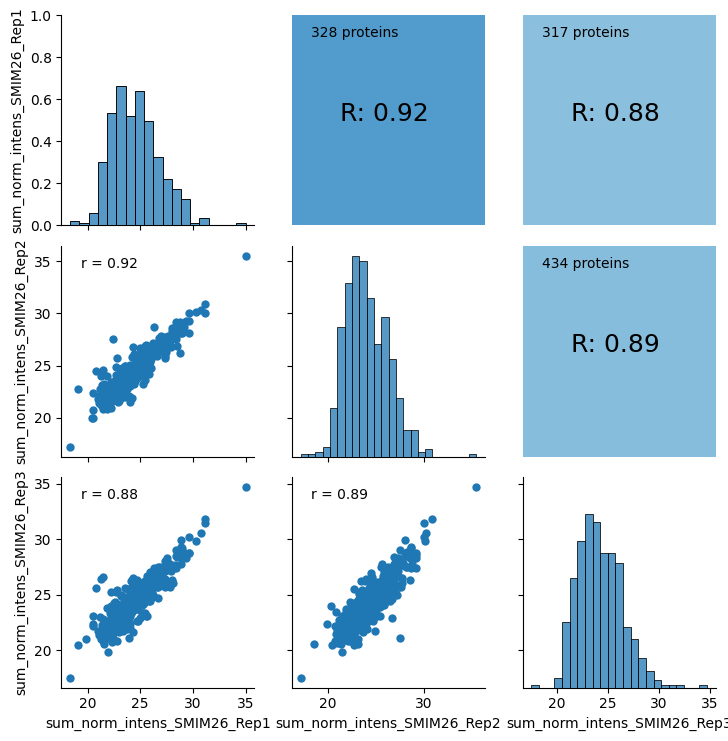

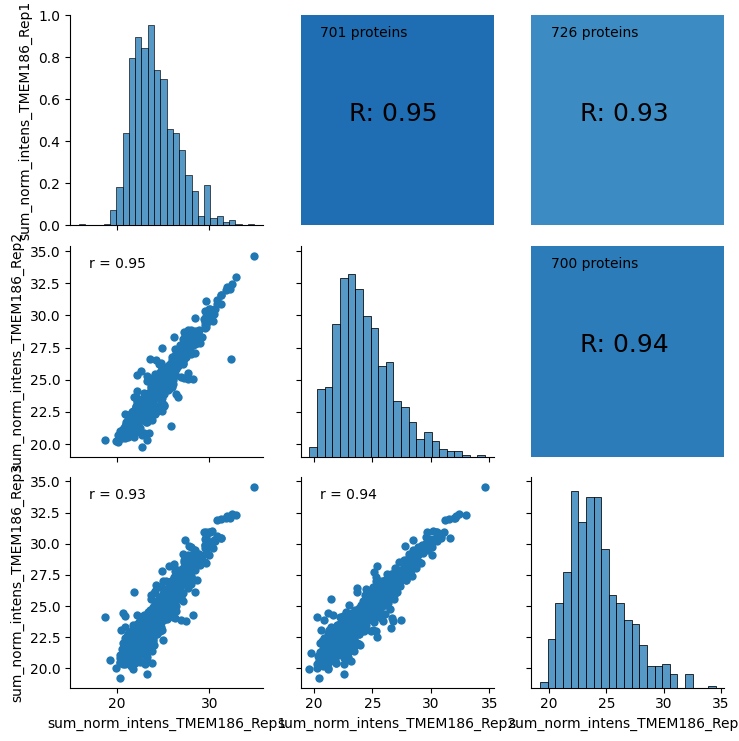

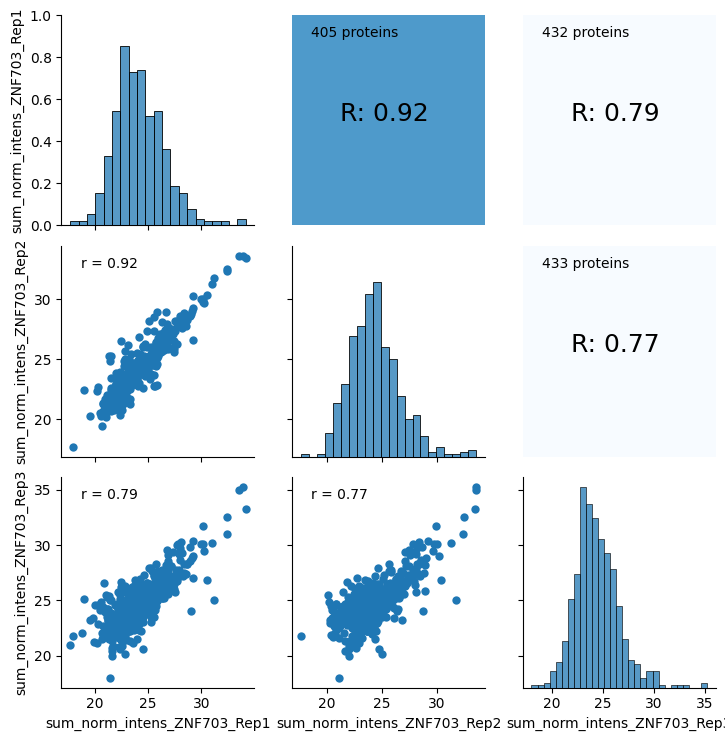

In [14]:
for exp in ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    cols = pg.filter(regex=f"sum_norm_intens_{exp}_Rep\d").columns.tolist()
    vis.correlogram(pg, cols)

In [15]:
# median imputation if values exist
control_intens_cols = pg.filter(regex="sum_norm_intens_Ctrl").columns.tolist()
# print
print(
    f"Row-wise median imputation for {len(pg) - pg[control_intens_cols].isnull().all(1).sum()} values."
)
# row-wise median imputation
pg[control_intens_cols] = pg.loc[
    ~pg[control_intens_cols].isnull().all(1), control_intens_cols
].apply(lambda row: row.fillna(row.median()), axis=1)

Row-wise median imputation for 166 values.


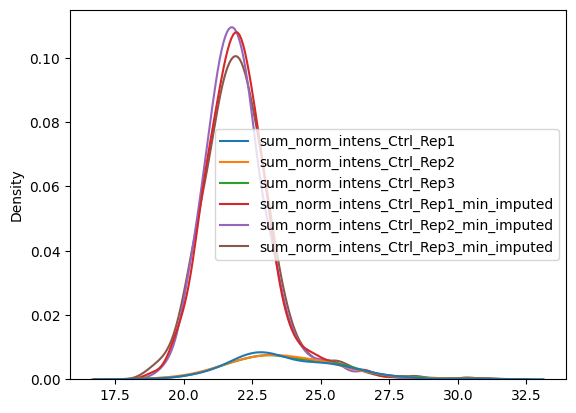

In [16]:
pg = pp.imp_min_prob(pg, cols_to_impute=control_intens_cols, downshift=1, width=0.5)
sns.kdeplot(pg.filter(regex="sum_norm_intens_Ctrl"))
plt.show()

In [17]:
for_pca = []
for exp in ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]:
    for rep in range(1, 4):
        # sum all slices per replicate
        for_pca.append(f"sum_norm_intens_{exp}_Rep{rep}")

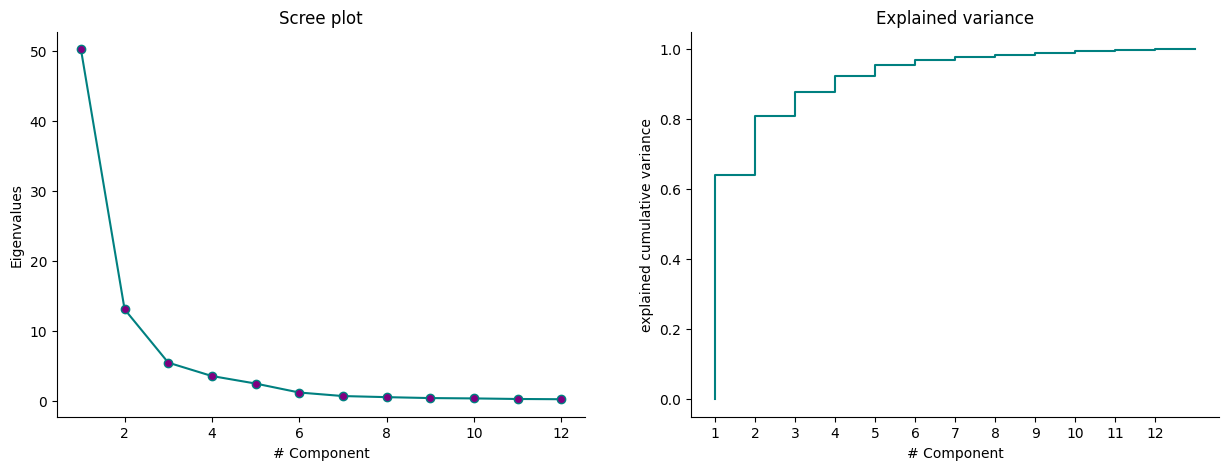

In [18]:
pca = ana.AutoPCA(
    pg[for_pca], clabels=None, batch=[x[16:] for x in for_pca], rlabels=None
)
pca.scree()

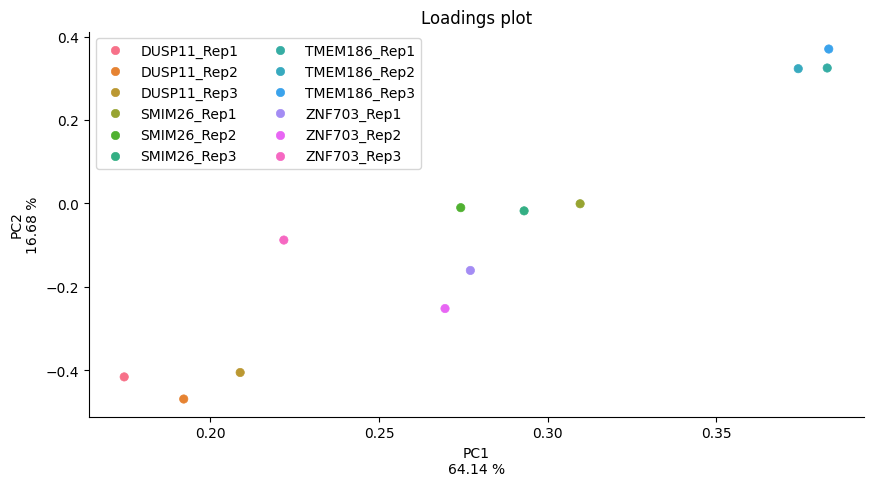

In [19]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))
pca.loading_plot(pc1=1, pc2=2, labeling=True, ax=ax)
plt.legend(ncol=2)
plt.show()

In [20]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]

for exp in experiments:
    fished = pg.filter(regex=f"sum_norm_intens_{exp}")
    control = pg.filter(regex="sum_norm_intens_Ctrl_.*_min_imputed")

    # calculate log2 ratio fished vs. control
    pg[[f"Ratio_{exp}_Rep{i+1}" for i in range(fished.shape[1])]] = (
        fished.values - control.values
    )

    pg = ana.limma(
        pg,
        reps=[f"Ratio_{exp}_Rep{i+1}" for i in range(fished.shape[1])],
        cond=f"_limma_{exp}",
    )

LIMMA: Assuming a one sample test
LIMMA: Assuming a one sample test
LIMMA: Assuming a one sample test
LIMMA: Assuming a one sample test


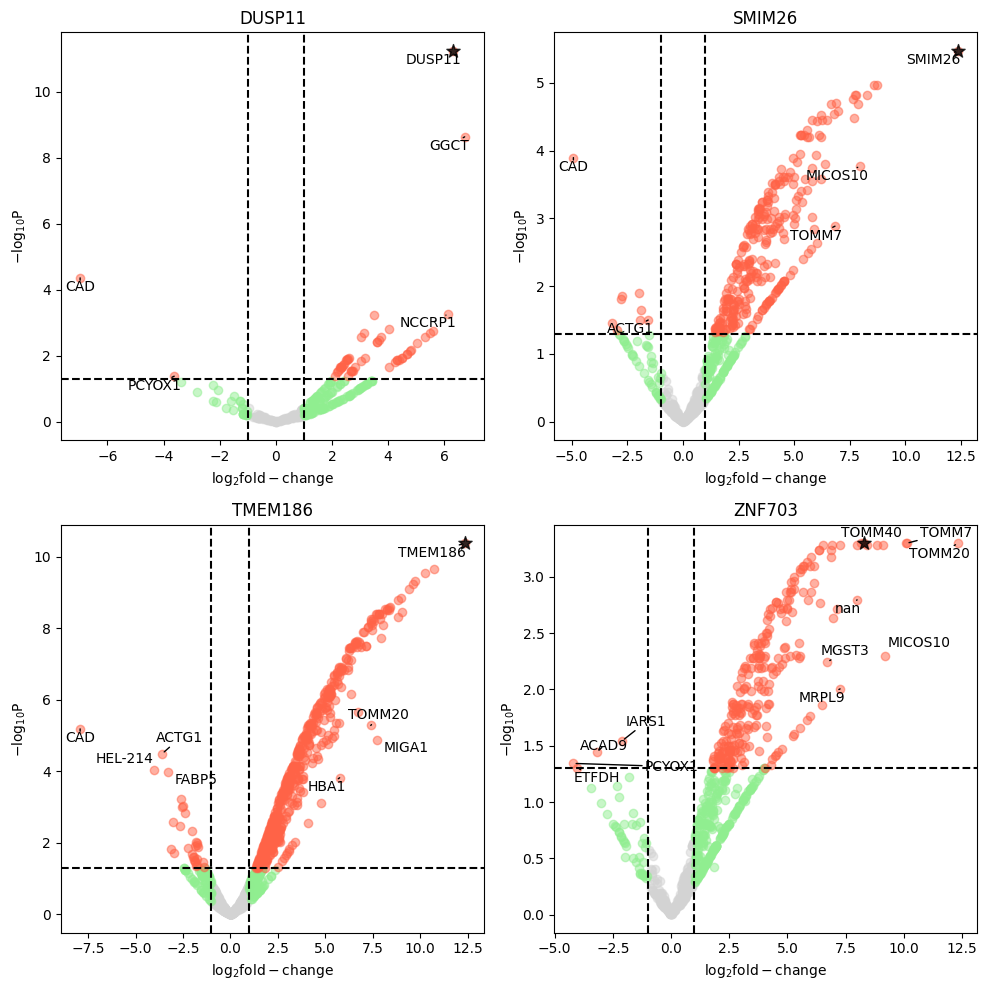

In [21]:
experiments = ["DUSP11", "SMIM26", "TMEM186", "ZNF703"]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for exp, ax in zip(experiments, axs.flatten()):
    highlight = pg[pg["Gene names first"] == exp].index

    vis.volcano(
        pg,
        highlight=highlight,
        kwargs_highlight={"color": "black", "marker": "*", "s": 100},
        log_fc_colname=f"logFC_limma_{exp}",
        p_colname=f"adj.P.Val_limma_{exp}",
        annotate_colname="Gene names first",
        ax=ax,
        show_caption=False,
        show_legend=False,
        annotate_density=50,
    )

    ax.set_title(exp)

plt.tight_layout()
plt.savefig("VolcanoPlot_DUSP11_SMIM26_TMEM186_ZNF703.png", dpi=300)